In [1]:
import psycopg2
from psycopg2 import OperationalError

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import HTML
import webbrowser

import os
os.chdir('/home/francisco/MECAD/2º Ano/Estágio/forcera/scripts/scripts_py')

# Importar funções e flags definidas em flags.py e functions.py
from functions import *
from flags import * 

***
    
# Ligação à base de dados

***

In [2]:
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")

cur = conn.cursor()

***

    Executar este comando quando ocorrer um erro ao tentar realizar uma query

***

In [3]:
cur.execute('''ROLLBACK;''')

***

# Exploração do Data Set

***

    Organizar Contratos por Tipo de Procedimento

In [4]:
cur = conn.cursor()
cur.execute('''
        SELECT tipo_procedimento, COUNT (tipo_procedimento)
        FROM "contratos"
        GROUP BY "tipo_procedimento"
        ORDER BY COUNT(tipo_procedimento) DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Ajuste Direto Regime Geral,144642
Consulta Prévia,62174
Concurso público,42020
Ao abrigo de acordo-quadro (art.º 259.º),31865
Ao abrigo de acordo-quadro (art.º 258.º),8562
Ajuste direto simplificado,3291
"Ajuste direto simplificado ao abrigo da Lei n.º 30/2021, de 21.05",1000
Consulta Prévia Simplificada,590
Concurso limitado por prévia qualificação,505
Concurso público simplificado,36


In [5]:
cur = conn.cursor()

cur.execute('''
        SELECT "contractTypes", COUNT ("contractTypes")
        FROM "contratos"
        WHERE tipo_procedimento = 'Ajuste Direto Regime Geral'
        GROUP BY "contractTypes"
        ORDER BY  COUNT("contractTypes") DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Aquisição de serviços,70464
Aquisição de bens móveis,66536
Empreitadas de obras públicas,4808
Locação de bens móveis,1422
Aquisição de serviços<br/>Aquisição de bens móveis,476
Aquisição de bens móveis<br/>Aquisição de serviços,469
Concessão de obras públicas,74
Locação de bens móveis<br/>Aquisição de serviços,65
Aquisição de serviços<br/>Locação de bens móveis,65
Concessão de serviços públicos,57


***

# Funções


***

    Restringir por CPV - 72 IT services: consulting, software development, Internet and support

In [6]:
cur = conn.cursor()
cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE cpv LIKE '72%';''')

len(cur.fetchall())

10937

In [7]:
ajdir = cpv('72','Ajuste Direto Regime Geral')
cpub = cpv('72', 'Concurso público')

***

    Lista de de Contratos Públicos
    
***

In [8]:
contratos(cpub)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323405,15555/2023,137670.00,6,False,6699898,13437191,2023-09-19,182,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382733
1,10322139,13241/2023,592500.00,36,False,6640568,13311154,2023-08-04,151,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699384415
2,10324626,15934/2023,150151.14,3,False,6708714,13455812,2023-09-25,186,2,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699386436
3,10325177,1698/2023,1749480.72,36,False,6512074,13055482,2023-07-28,146,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699385716
4,9421165,9468/2022,195239.58,9,False,6016334,12041438,2022-07-26,143,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701408303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,10376333,2340/2023,3606995.90,9,False,6688249,13409479,2023-10-13,199,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701923819
1354,9390723,7495/2022,209520.00,6,False,5951308,11914211,2022-06-13,113,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,200412.00,1701923917
1355,10376227,18381/2023,87516.00,6,True,6760363,13570983,2023-11-02,212,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701923976
1356,9390552,7528/2022,150400.00,6,False,5952717,11917646,2022-06-14,114,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,147840.00,1701924138


***

    Lista de Ajustes Diretos 

***

In [9]:
contratos(ajdir)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323628,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
1,10323670,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382337
2,10324799,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699386139
3,10326169,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
4,10322803,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699383587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6776,10375993,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1701924284
6777,9390413,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701924318
6778,10375937,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701924332
6779,9390367,None,None,None,None,None,None,None,None,None,...,None,None,True,None,True,N/A,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701924393


***

# Ajuste Direto Regime Geral

***

In [26]:
# ajdir são os id's dos contratos referentes a ajustes diretos
# ajustesdir é uma dataframe que contém todas as colunas da DB referentes a ajustes diretos
ajustesdir = contratos(ajdir)

# Renomear colunas dos preços base e contratual
ajustesdir = ajustesdir.rename(columns={0:'ID', 18:'PrecoContratual', 38:'TipoProcedimento'})

# Conversão dos precos contratuais para float a fim de os comparar aos preços base
ajustesdir.PrecoContratual = ajustesdir.iloc[:,18].astype('float')

# Sumário Estatístico dos Preços contratuais
ajustesdir.PrecoContratual.describe().apply(lambda x: format(x, '.2f'))

count       6781.00
mean       33496.38
std       183369.61
min            0.00
25%         7200.00
50%        13225.00
75%        19999.99
max      9622557.36
Name: PrecoContratual, dtype: object

In [27]:
h(ajustesdir.head(5))

ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,PrecoContratual,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,TipoProcedimento,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
10323628,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Serviço Via Verde Estacionar,2023-11-02,2023-10-20,19990.00,731,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da (505072947)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381)","Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A. (504656767)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071227&ext=.pdf,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,19990.0,Ajuste Direto N.º 08/23 - Serviço Via Verde Estacionar,Não aplicável,None,"Portugal, Lisboa, Loures",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
10323670,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Prestação de Serviços de Assistência Técnica Informática,2023-11-02,2023-10-04,10000.00,366,Freguesia de São Gonçalo de Lagos (510837433)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=934188),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos",Algardata Sistemas Informáticos SA (502420227)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=320),None,None,None,None,false,72611000-6,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de assistência técnica informática,Principal,10000.0,Prestação de Serviços de Assistência Técnica Informática,Não aplicável,None,"Portugal, Faro, Lagos",Não aplicável.,Não aplicável.,None,False,False,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou de aquisição de bens móveis ou de aquisição de serviços cujo preço contratual não excede 10.000,00 € e para Região Autónoma da Madeira um coeficiente de 1,35 €",True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699382337
10324799,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Aquisição de serviços - Disponibilização da Plataforma de Gestão Escolar Integrada,2023-11-03,2023-11-03,19847.77,67,Município de Guimarães (505948605)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1867),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","CTT Soluções Empresariais, S.A. (516165887)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=3933251)",None,None,https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/Njg2OTE3,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071465&ext=.pdf,false,72500000-0,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços relacionados com a informática,Principal,19847.77,Aquisição de serviços - Disponibilização da Plataforma de Gestão Escolar Integrada,ausência de recursos próprios,None,"Portugal, Braga, Guimarães",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699386139
10326169,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,"Aquisição de licenciamento e serviços de manutenção evolutiva do sistema de gestão documental da AMA:\na) Fornecimento de licenciamento MindBreeze, módulo de pesquisa de reconhecimento ótico para o software Fabasoft e-Gov Suite;\nb) Prestação de serviços de melhoria evolutiva do sistema de gestão documental.",2023-11-03,2023-11-02,350

In [13]:
ajustesdir.TipoProcedimento.value_counts()

TipoProcedimento
Aquisição de serviços                                                      6712
Aquisição de bens móveis<br/>Aquisição de serviços                           28
Aquisição de serviços<br/>Aquisição de bens móveis                           24
Locação de bens móveis<br/>Aquisição de serviços                              6
Concessão de serviços públicos                                                3
Concessão de serviços públicos<br/>Aquisição de serviços                      2
Aquisição de serviços<br/>Locação de bens móveis                              2
Aquisição de serviços<br/>Sociedade                                           2
Empreitadas de obras públicas<br/>Aquisição de serviços                       1
Outros Tipos (Prestação do Serviço Universal)<br/>Aquisição de serviços       1
Name: count, dtype: int64

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='PrecoContratual', ylabel='Count'>

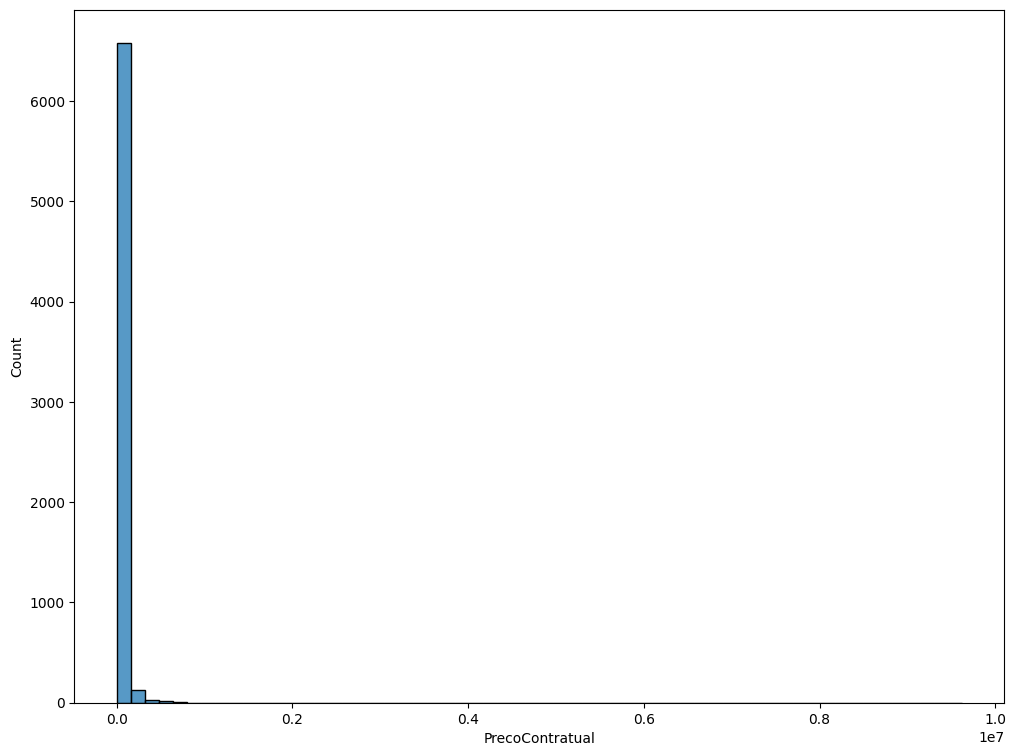

In [14]:
plt.figure(figsize=(12,9))
sns.histplot(ajustesdir.PrecoContratual, bins = 60)

<Axes: >

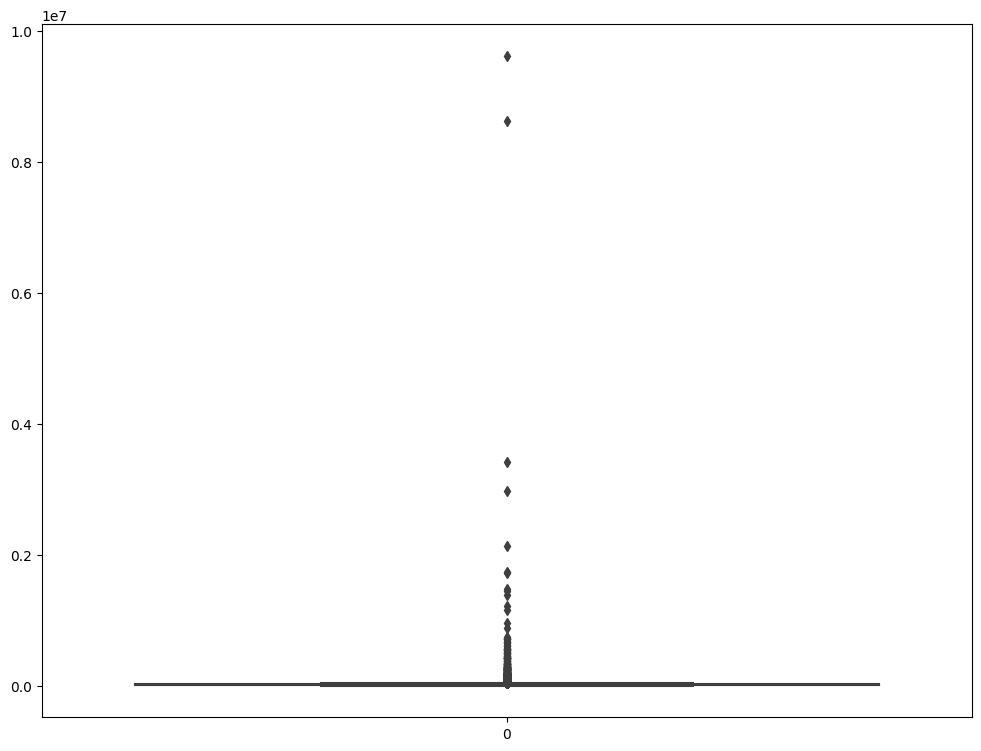

In [15]:
plt.figure(figsize=(12,9))
sns.boxplot(ajustesdir.PrecoContratual)

In [16]:
# Conjunto de fundamentações para ajustes diretos por ordem decrescente de ocorrência
(ajustesdir).groupby(21).size().sort_values(ascending = False)

21
Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos                                                     3527
Artigo 24.º, n.º 1, alínea e), subalínea iii) do Código dos Contratos Públicos                                     1346
Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos                                      1296
Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos e artigo 4.º, nº 1 do DLR nº 34/2008/M, de 14.08     143
Artigo 24.º, n.º 1, alínea c) do Código dos Contratos Públicos                                                      121
Artigo 20.º, alínea a) do Decreto Legislativo Regional n.º 27/2015/A, de 29.12                                       95
Artigo 21.º, n.º 1, alínea c) do Código dos Contratos Públicos                                                       46
Artigo 24.º, n.º 1, alínea e), subalínea i) do Código dos Contratos Públicos                                         41
Artigo 26.º, n.º 1, alínea a) do Códi

In [40]:
ajustesdir.ID

0       10323628
1       10323670
2       10324799
3       10326169
4       10322803
          ...   
6776    10375993
6777     9390413
6778    10375937
6779     9390367
6780     9389983
Name: ID, Length: 6781, dtype: object

In [38]:
# Valor máximo de um ajuste direto é mais de 3.000.000,00€

# Índice do array do valor mais alto 
print(np.where(ajustesdir.PrecoContratual > 6000000)[0])

# ID do contrato correspondente
print(ajdir[5538], ajustesdir.PrecoContratual[5538], ajustesdir.ID[5538])

h(ajustesdir[ajustesdir.ID == '9489224'])

[2245 5538]
('9692564',) 9622557.36 9489224


ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,PrecoContratual,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,TipoProcedimento,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
9489224,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Aquisição de serviços de gestão e operação tecnológica dos pontos de venda de Jogos Sociais do Estado,2022-10-10,2022-10-03,9622557.36,731,Santa Casa da Misericórdia de Lisboa (500745471)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=11667),"Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos",IGT FOREIGN HOLDINGS CORPORATION (980213215)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=94278),None,None,https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTc2MTQw,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=1900485&ext=.pdf,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,9622557.36,Aquisição de serviços de gestão e operação tecnológica dos pontos de venda de Jogos Sociais do Estado,Não especificado,None,Portugal,Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1701563543


In [48]:
# ID's dos contratos com flag
rflag = redflag2(ajustesdir, ajustesdir.ID)

In [52]:
# Ajustes Diretos com preço contratual superior a 20.000€
h(contratos(rflag).head(2))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
10326169,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,"Aquisição de licenciamento e serviços de manutenção evolutiva do sistema de gestão documental da AMA:\na) Fornecimento de licenciamento MindBreeze, módulo de pesquisa de reconhecimento ótico para o software Fabasoft e-Gov Suite;\nb) Prestação de serviços de melhoria evolutiva do sistema de gestão documental.",2023-11-03,2023-11-02,35000.00,427,"Agência Para A Modernização Administrativa, Ip (508184509)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=99)","Artigo 24.º, n.º 1, alínea e), subalínea iii) do Código dos Contratos Públicos","Unipartner IT Services, S.A. (513662332)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1031653)",None,None,https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/Njg1Mzg1,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071630&ext=.pdf,false,72200000-7,False,None,None,False,False,None,False,None,False,Aquisição de serviços<br/>Aquisição de bens móveis,Serviços de consultoria e de programação de software,Principal,35000.0,"Aquisição de licenciamento e serviços de manutenção evolutiva do sistema de gestão documental da AMA:\na) Fornecimento de licenciamento MindBreeze, módulo de pesquisa de reconhecimento ótico para o software Fabasoft e-Gov Suite;\nb) Prestação de serviços de melhoria evolutiva do sistema de gestão documental.",ausência de recursos próprios,None,"Portugal, Lisboa, Lisboa",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
10324999,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Aquisição de serviços para a Renovação da subscrição de Feeds – Open Source Intel - Artic Security,2023-11-03,2023-06-26,34000.00,1096,Gabinete Nacional de Segurança (GNS) (600056120)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=68917),"Artigo 24.º, n.º 1, alínea e), subalínea i) do Código dos Contratos Públicos",Arctic Security (FI28462522)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4861458),None,None,None,None,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,34000.0,Renovação da subscrição de Feeds – Open Source Intel - Artic Security,Não aplicável,None,"Portugal, Lisboa, Lisboa",Não aplicável.,Não aplicável.,None,False,False,None,None,True,"Artigo 95.º, n.º 2, a), a segurança pública interna ou externa justifica-o",True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385859


In [56]:
print('Nr de Ajustes Diretos :', len(ajustesdir))
print('Nr de Ajustes Diretos Suspeitos :', len(contratos(rflag)))
print('% = ', round(len(contratos(rflag))/len(ajustesdir), 3)*100 )

Nr de Ajustes Diretos : 6781
Nr de Ajustes Diretos Suspeitos : 1673
% =  24.7


In [57]:
# As colunas da dataframe de entidade adjudicante e entidade adjudicataria vão ser decompostas em 3 novas colunas: Entidade-NIF-URL
ajustesdir = ajustesdir.rename(columns={0 : 'ID', 20: 'Adjudicante', 21:'Fundamentação', 22:'Adjudicatária'})


# Separação dos elementos de cada coluna em Entidade-NIF-URL
# O objetivo é contar o número de ocorrências de cada NIF
pattern = r'^(?P<EntidadeAdjudicante>.*?)\s?\((?P<NIF1>[\w\.-]+)\)\((?P<URL1>.*?)\)$'
pattern1 = r'^(?P<EntidadeAdjudicataria>.*?)\s?\((?P<NIF2>[\w\.-]+)\)\((?P<URL2>.*?)\)$'


Df_extracted = ajustesdir['Adjudicante'].str.extract(pattern)
Df_extracted1 = ajustesdir['Adjudicatária'].str.extract(pattern1)


# Correr linhas abaixo só uma vez
# Caso contrário está sempre a adicionar à dataframe as mesas colunas
ajustesdir = pd.concat([ajustesdir, Df_extracted], axis=1)
ajustesdir = pd.concat([ajustesdir, Df_extracted1], axis=1)


h(ajustesdir.head(2))

ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,PrecoContratual,19,Adjudicante,Fundamentação,Adjudicatária,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,TipoProcedimento,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,EntidadeAdjudicante,NIF1,URL1,EntidadeAdjudicataria,NIF2,URL2
10323628,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Serviço Via Verde Estacionar,2023-11-02,2023-10-20,19990.0,731,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da (505072947)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381)","Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A. (504656767)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071227&ext=.pdf,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,19990.0,Ajuste Direto N.º 08/23 - Serviço Via Verde Estacionar,Não aplicável,None,"Portugal, Lisboa, Loures",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da",505072947,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381,"Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A.",504656767,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977
10323670,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Prestação de Serviços de Assistência Técnica Informática,2023-11-02,2023-10-04,10000.0,366,Freguesia de São Gonçalo de Lagos (510837433)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=934188),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos",Algardata Sistemas Informáticos SA (502420227)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=320),None,None,None,None,false,72611000-6,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de assistência técnica informática,Principal,10000.0,Prestação de Serviços de Assistência Técnica Informática,Não aplicável,None,"Portugal, Faro, Lagos",Não aplicável.,Não aplicável.,None,False,False,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou de aquisição de bens móveis ou de aquisição de serviços cujo preço contratual não excede 10.000,00 € e para Região Autónoma da Madeira um coeficiente de 1,35 €",True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699382337,Freguesia de São Gonçalo de Lagos,510837433,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=934188,Algardata Sistemas Informáticos SA,502420227,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=320


FAZER : 

**Ao lado de cada NIF inserir o valor total de todas as transações por ano**

In [58]:
counts = ajustesdir.groupby('NIF1').size().reset_index(name='Count')
counts1 = ajustesdir.groupby('NIF2').size().reset_index(name='Count')

# Entidades Adjudicantes com mais ajustes diretos celebrados
h(counts.sort_values(by = ['Count'], ascending=False))

NIF1,Count
502017368,128
501413197,80
501559094,65
500225680,60
501306099,57
508786193,53
500051070,52
506361616,50
600012662,50
508142156,49


In [60]:
# Entidades Adjudicatárias com mais ajustes diretos celebrados
h(counts1.sort_values(by = ['Count'], ascending=False))

NIF2,Count
-,376
501378669,196
502479418,111
504615947,107
504990926,101
505331187,98
511135610,74
501941231,70
504551221,69
505141019,68


In [61]:
C1 = counts.sort_values(by = ['Count'], ascending=False)
C2 = counts1.sort_values(by = ['Count'], ascending=False)

In [62]:
def e_adjudicante(df,nif):
    """
    Função que retorna id's dos contratos a partir do NIF da entidade adjudicante

    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        ids dos ajustes diretos celebrados para a entidade adjudicante com o NIF em questão
    """

    index = (np.where(df.NIF1 == nif)[0])
    ids = np.array(df.iloc[index,0])

    ids = ids.reshape((len(ids),1))
    ids = tuple(map(tuple,ids))
    
    return ids



def e_adjudicataria(df,nif):
    """
    Função que retorna id's dos contratos a partir do NIF da entidade adjudicatária

    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        ids dos ajustes diretos celebrados para a entidade adjudicatária com o NIF em questão
    """

    index = (np.where(df.NIF2 == nif)[0])
    ids = np.array(df.iloc[index,0])

    ids = ids.reshape((len(ids),1))
    ids = tuple(map(tuple,ids))
    
    return ids

In [63]:
def entidadeI(df,nif):
    """
    Função que retorna nome da entidade adjudicante a partir do NIF
    
    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        nome da entidade
    """

    index = (np.where(df.NIF1 == nif)[0])
    i = index[0]
    
    return df.EntidadeAdjudicante[i]



def entidadeII(df,nif):
    """
    Função que retorna nome da entidade adjudicatária a partir do NIF
    
    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        nome da entidade
    """

    index = (np.where(df.NIF2 == nif)[0])
    i = index[0]
    
    return df.EntidadeAdjudicataria[i]

In [64]:
# PARA ENTIDADES ADJUDICANTES

# Este array vai servir para guardar o número de ajustes diretos suspeitos para cada NIF
# O NIF com mais ajustes diretos está na posição 0 do array, o segundo na posição 1 e assim sucessivamente
# Neste caso, o número de ajustes diretos suspeitos referentes à empresa com mais ajustes diretos realizados está na posição 0
ents = np.zeros(len(C1.NIF1))

# Lista com os nomes das entidades adjudicantes
name = list()

# Lista que vai conter o número de ajustes diretos realizados para cada entidade
cel  = np.zeros(len(C1.NIF1))


for i,j in enumerate(C1.NIF1):

    # Nome da entidade adjudicante
    name.append(entidadeI(ajustesdir, j))

    # ID's dos ajustes diretos celebrados
    x = e_adjudicante(ajustesdir,j)

    # Número de ajustes diretos celebrados
    cel[i] = len(x)
    
    for k in x:
        if k in rflag:
            ents[i] += 1        

# Percentagem de contratos suspeitos
perc = np.round(ents/cel*100,2)

newdf = pd.DataFrame({'EntidadeAdjudicante': name, 'NIF':C1.NIF1, 'Celebrados': cel, 'Suspeitos': ents, '%':perc})
h(newdf)

EntidadeAdjudicante,NIF,Celebrados,Suspeitos,%
Autoridade Nacional de Comunicações,502017368,128.0,31.0,24.22
Universidade do Porto,501413197,80.0,19.0,23.75
Universidade Nova de Lisboa,501559094,65.0,8.0,12.31
"Rádio e Televisão de Portugal, S. A.",500225680,60.0,14.0,23.33
Município do Porto,501306099,57.0,14.0,24.56
"Unidade Local de Saúde do Alto Minho, E. P. E.",508786193,53.0,10.0,18.87
Município de Lisboa,500051070,52.0,17.0,32.69
"Instituto Português de Oncologia de Lisboa Francisco Gentil, E. P. E.",506361616,50.0,17.0,34.00
Ministério da Defesa Nacional - Marinha,600012662,50.0,11.0,22.00
"Centro Hospitalar Vila Nova de Gaia - Espinho, E. P. E.",508142156,49.0,18.0,36.73


In [65]:
# PARA ENTIDADES ADJUDICATÁRIAS

# Este array vai servir para guardar o número de ajustes diretos suspeitos para cada NIF
# O NIF com mais ajustes diretos está na posição 0 do array, o segundo na posição 1 e assim sucessivamente
# Neste caso, o número de ajustes diretos suspeitos referentes à empresa com mais ajustes diretos realizados está na posição 0
ents1 = np.zeros(len(C2.NIF2))

# Lista com os nomes das entidades adjudicatárias
name1 = list()

# Lista que vai conter o número de ajustes diretos realizados para cada entidade
cel1  = np.zeros(len(C2.NIF2))


for i,j in enumerate(C2.NIF2):
    
    # Nome da entidade adjudicante
    name1.append(entidadeII(ajustesdir, j))

    # ID's dos ajustes diretos celebrados
    x1 = e_adjudicataria(ajustesdir,j)

    # Número de ajustes diretos celebrados
    cel1[i] = len(x1)
    
    for k in x1:
        if k in rflag:
            ents1[i] += 1        

# Percentagem de contratos suspeitos
perc1 = np.round(ents1/cel1*100,2)

newdf1 = pd.DataFrame({'EntidadeAdjudicatárias': name1, 'NIF':C2.NIF2, 'Celebrados': cel1, 'Suspeitos': ents1, '%':perc1})
h(newdf1)

EntidadeAdjudicatárias,NIF,Celebrados,Suspeitos,%
Vítor José Cardoso Parada,-,376.0,4.0,1.06
AIRC - Associação de Informática da Região Centro,501378669,196.0,124.0,63.27
"GLINTT - HEALTHCARE SOLUTIONS, SA.",502479418,111.0,61.0,54.95
"MEO - Serviços de Comunicações e Multimédia, S. A.",504615947,107.0,18.0,16.82
Medidata,504990926,101.0,60.0,59.41
WireMaze - Sistemas de Informação S.A.,505331187,98.0,17.0,17.35
"ACIN-ICLOUD Solutions, Lda.",511135610,74.0,3.0,4.05
"ESRI Portugal - Sistemas de Informação Geográfica, S.A.",501941231,70.0,32.0,45.71
"Link Consulting - Tecnologias de Informação, S.A.",504551221,69.0,25.0,36.23
"Vortal - Comércio Eletrónico Consultadoria e Multimédia, S. A",505141019,68.0,1.0,1.47


In [66]:
n1 = np.array(ajustesdir.NIF1)
n2 = np.array(ajustesdir.NIF2)

print('Número de Ajustes Diretos :', len(n1))
print('Número de NIFs de entidades adjudicantes :', len(C1)) 
print('Número de NIFs de entidades adjudicatárias :', len(C2)) 

Número de Ajustes Diretos : 6781
Número de NIFs de entidades adjudicantes : 1277
Número de NIFs de entidades adjudicatárias : 1824


# Plots

In [67]:
cur = conn.cursor()
cur.execute('''
            SELECT column_name
            FROM information_schema.columns
            WHERE table_name = 'contratos';''')

h(pd.DataFrame(cur.fetchall()))

0
id
n_anuncio
anuncio_preco_base
anuncio_proposalDeadline
anuncio_cnccs
anuncio_contractingProcedureAliasID
anuncio_contractingProcedureId
anuncio_drPublicationDate
anuncio_dreNumber
anuncio_dreSeries


In [68]:
def contracts_year(Y):

    cur = conn.cursor()
    cur.execute('''
                SELECT COUNT(*) 
                FROM "contratos"
                WHERE EXTRACT(YEAR FROM data_publicacao::timestamp) = %s;''', (Y,))
    
    return cur.fetchone()[0]

In [69]:
def pcontratual_ano(year):
    cur = conn.cursor()
    cur.execute('''
                SELECT SUM(CAST(preco_contratual AS FLOAT))
                FROM "contratos"
                WHERE EXTRACT(YEAR FROM data_publicacao::timestamp) = %s;''', (year,))
    
    return cur.fetchone()[0]

In [70]:
C2023 = contracts_year(2023)
P2023 = pcontratual_ano(2023)

C2022 = contracts_year(2022)
P2022 = pcontratual_ano(2022)

In [71]:
print(C2023,P2023,C2022,P2022)

176941 13891075800.970028 117830 8560937563.510035


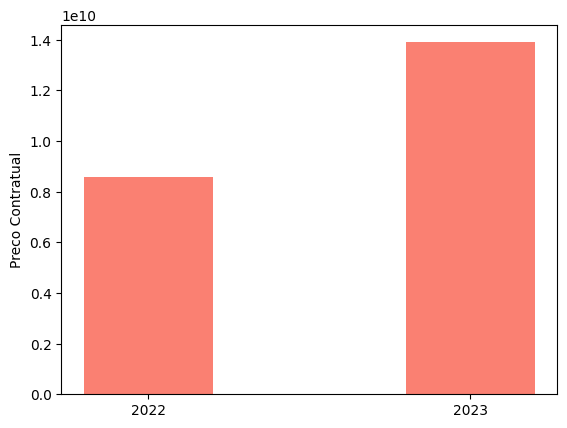

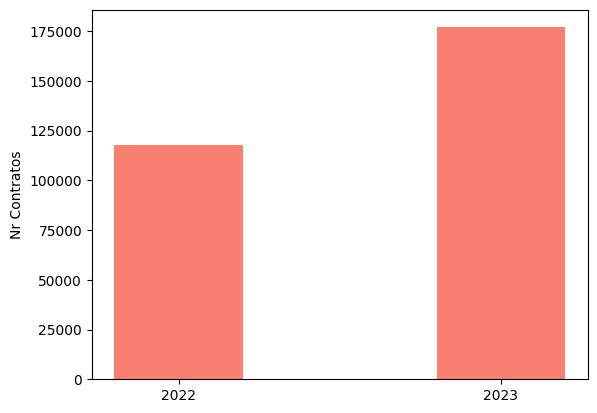

In [72]:
anos = np.array([2022, 2023])
prices = np.array([P2022,P2023])
contracts = np.array([C2022,C2023])

plt.bar(anos, prices, tick_label = [2022,2023], width = .4, align = 'center', color = 'salmon')
plt.ylabel('Preco Contratual')
plt.show()

plt.bar(anos, contracts, tick_label = [2022,2023], width = .4, align = 'center', color = 'salmon')
plt.ylabel('Nr Contratos')
plt.show()